In [14]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests
import os
import glob
import pandas as pd

In [15]:
# load image from the IAM database (actually this model is meant to be used on printed text)
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
train_df = pd.read_csv('DataTrain.csv', delimiter=';')

In [17]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(train_df, test_size=0.2)

In [18]:
train_df = train_df.drop(train_df.columns[0], axis=1)

In [19]:
train_df = train_df.rename(columns={train_df.columns[0]: "text", train_df.columns[1]: "file_name"}, inplace=False)

In [21]:
import torch
from torch.utils.data import Dataset

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [22]:
train_dataset = IAMDataset(root_dir=os.path.join(os.getcwd(),'Train-Data/'),
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir=os.path.join(os.getcwd(),'Train-Data/'),
                           df=test_df,
                           processor=processor)

In [23]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 640
Number of validation examples: 160


In [10]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


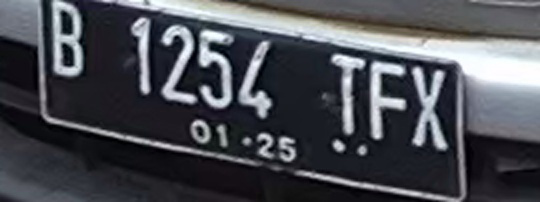

In [11]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [12]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

B1254TFX


In [13]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [21]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=False, 
    output_dir="./",
    logging_steps=2,
    save_steps=100,
    eval_steps=20,
)

In [17]:
from datasets import load_metric

cer_metric = load_metric("cer")

/var/folders/ht/1vg09v7x16x7sbqnmzfvc4600000gn/T/ipykernel_53543/152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [19]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [22]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/Users/rsoedarnadi/opt/anaconda3/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/rsoedarnadi/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/240 [00:00<?, ?it/s]

{'loss': 7.2545, 'learning_rate': 4.958333333333334e-05, 'epoch': 0.03}
{'loss': 1.6405, 'learning_rate': 4.9166666666666665e-05, 'epoch': 0.05}
{'loss': 1.1053, 'learning_rate': 4.875e-05, 'epoch': 0.07}
{'loss': 0.5721, 'learning_rate': 4.8333333333333334e-05, 'epoch': 0.1}
{'loss': 0.9622, 'learning_rate': 4.791666666666667e-05, 'epoch': 0.12}
{'loss': 1.3671, 'learning_rate': 4.75e-05, 'epoch': 0.15}
{'loss': 0.9726, 'learning_rate': 4.708333333333334e-05, 'epoch': 0.17}
{'loss': 0.5415, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.2}
{'loss': 1.2514, 'learning_rate': 4.6250000000000006e-05, 'epoch': 0.23}
{'loss': 0.4805, 'learning_rate': 4.5833333333333334e-05, 'epoch': 0.25}


/Users/rsoedarnadi/opt/anaconda3/lib/python3.9/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.731465220451355, 'eval_cer': 0.16487158243579123, 'eval_runtime': 2016.813, 'eval_samples_per_second': 0.079, 'eval_steps_per_second': 0.01, 'epoch': 0.25}
{'loss': 0.5995, 'learning_rate': 4.541666666666667e-05, 'epoch': 0.28}
{'loss': 1.0444, 'learning_rate': 4.5e-05, 'epoch': 0.3}
{'loss': 0.3571, 'learning_rate': 4.458333333333334e-05, 'epoch': 0.33}
{'loss': 0.3425, 'learning_rate': 4.4166666666666665e-05, 'epoch': 0.35}
{'loss': 0.4309, 'learning_rate': 4.375e-05, 'epoch': 0.38}
{'loss': 0.7666, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}
{'loss': 0.6907, 'learning_rate': 4.291666666666667e-05, 'epoch': 0.42}
{'loss': 0.4718, 'learning_rate': 4.25e-05, 'epoch': 0.45}
{'loss': 0.582, 'learning_rate': 4.208333333333334e-05, 'epoch': 0.47}
{'loss': 0.7275, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.5}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.6629596948623657, 'eval_cer': 0.1267605633802817, 'eval_runtime': 1331.8487, 'eval_samples_per_second': 0.12, 'eval_steps_per_second': 0.015, 'epoch': 0.5}
{'loss': 0.5128, 'learning_rate': 4.125e-05, 'epoch': 0.53}
{'loss': 0.444, 'learning_rate': 4.0833333333333334e-05, 'epoch': 0.55}
{'loss': 0.5173, 'learning_rate': 4.041666666666667e-05, 'epoch': 0.57}
{'loss': 0.4358, 'learning_rate': 4e-05, 'epoch': 0.6}
{'loss': 0.6399, 'learning_rate': 3.958333333333333e-05, 'epoch': 0.62}
{'loss': 0.4372, 'learning_rate': 3.9166666666666665e-05, 'epoch': 0.65}
{'loss': 0.3549, 'learning_rate': 3.875e-05, 'epoch': 0.68}
{'loss': 1.2485, 'learning_rate': 3.8333333333333334e-05, 'epoch': 0.7}
{'loss': 0.6749, 'learning_rate': 3.791666666666667e-05, 'epoch': 0.72}
{'loss': 0.3641, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.75}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.5972287654876709, 'eval_cer': 0.12178956089478045, 'eval_runtime': 1339.6375, 'eval_samples_per_second': 0.119, 'eval_steps_per_second': 0.015, 'epoch': 0.75}
{'loss': 0.862, 'learning_rate': 3.708333333333334e-05, 'epoch': 0.78}
{'loss': 0.6996, 'learning_rate': 3.6666666666666666e-05, 'epoch': 0.8}
{'loss': 0.2885, 'learning_rate': 3.625e-05, 'epoch': 0.82}
{'loss': 0.7368, 'learning_rate': 3.5833333333333335e-05, 'epoch': 0.85}
{'loss': 0.5053, 'learning_rate': 3.541666666666667e-05, 'epoch': 0.88}
{'loss': 0.555, 'learning_rate': 3.5e-05, 'epoch': 0.9}
{'loss': 0.5235, 'learning_rate': 3.458333333333333e-05, 'epoch': 0.93}
{'loss': 0.2258, 'learning_rate': 3.4166666666666666e-05, 'epoch': 0.95}
{'loss': 0.4604, 'learning_rate': 3.375000000000001e-05, 'epoch': 0.97}
{'loss': 0.6383, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.51189124584198, 'eval_cer': 0.10770505385252693, 'eval_runtime': 1136.547, 'eval_samples_per_second': 0.141, 'eval_steps_per_second': 0.018, 'epoch': 1.0}
{'loss': 0.2414, 'learning_rate': 3.291666666666667e-05, 'epoch': 1.02}
{'loss': 0.2006, 'learning_rate': 3.2500000000000004e-05, 'epoch': 1.05}
{'loss': 0.0985, 'learning_rate': 3.208333333333334e-05, 'epoch': 1.07}
{'loss': 0.1128, 'learning_rate': 3.1666666666666666e-05, 'epoch': 1.1}
{'loss': 0.3855, 'learning_rate': 3.125e-05, 'epoch': 1.12}
{'loss': 0.1973, 'learning_rate': 3.0833333333333335e-05, 'epoch': 1.15}
{'loss': 0.1445, 'learning_rate': 3.0416666666666666e-05, 'epoch': 1.18}
{'loss': 0.2125, 'learning_rate': 3e-05, 'epoch': 1.2}
{'loss': 0.3405, 'learning_rate': 2.9583333333333335e-05, 'epoch': 1.23}
{'loss': 0.1119, 'learning_rate': 2.916666666666667e-05, 'epoch': 1.25}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.4911894202232361, 'eval_cer': 0.09527754763877382, 'eval_runtime': 1795.5307, 'eval_samples_per_second': 0.089, 'eval_steps_per_second': 0.011, 'epoch': 1.25}
{'loss': 0.2009, 'learning_rate': 2.8749999999999997e-05, 'epoch': 1.27}
{'loss': 0.1576, 'learning_rate': 2.8333333333333335e-05, 'epoch': 1.3}
{'loss': 0.2657, 'learning_rate': 2.791666666666667e-05, 'epoch': 1.32}
{'loss': 0.3669, 'learning_rate': 2.7500000000000004e-05, 'epoch': 1.35}
{'loss': 0.3256, 'learning_rate': 2.7083333333333332e-05, 'epoch': 1.38}
{'loss': 0.2783, 'learning_rate': 2.6666666666666667e-05, 'epoch': 1.4}
{'loss': 0.2746, 'learning_rate': 2.625e-05, 'epoch': 1.43}
{'loss': 0.1098, 'learning_rate': 2.5833333333333336e-05, 'epoch': 1.45}
{'loss': 0.3097, 'learning_rate': 2.5416666666666667e-05, 'epoch': 1.48}
{'loss': 0.1815, 'learning_rate': 2.5e-05, 'epoch': 1.5}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.512377142906189, 'eval_cer': 0.09942004971002485, 'eval_runtime': 1694.7757, 'eval_samples_per_second': 0.094, 'eval_steps_per_second': 0.012, 'epoch': 1.5}
{'loss': 0.2621, 'learning_rate': 2.4583333333333332e-05, 'epoch': 1.52}
{'loss': 0.3603, 'learning_rate': 2.4166666666666667e-05, 'epoch': 1.55}
{'loss': 0.2201, 'learning_rate': 2.375e-05, 'epoch': 1.57}
{'loss': 0.2017, 'learning_rate': 2.3333333333333336e-05, 'epoch': 1.6}
{'loss': 0.3122, 'learning_rate': 2.2916666666666667e-05, 'epoch': 1.62}
{'loss': 0.2198, 'learning_rate': 2.25e-05, 'epoch': 1.65}
{'loss': 0.1528, 'learning_rate': 2.2083333333333333e-05, 'epoch': 1.68}
{'loss': 0.1189, 'learning_rate': 2.1666666666666667e-05, 'epoch': 1.7}
{'loss': 0.1604, 'learning_rate': 2.125e-05, 'epoch': 1.73}
{'loss': 0.1772, 'learning_rate': 2.0833333333333336e-05, 'epoch': 1.75}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.40925830602645874, 'eval_cer': 0.07042253521126761, 'eval_runtime': 1096.7251, 'eval_samples_per_second': 0.146, 'eval_steps_per_second': 0.018, 'epoch': 1.75}
{'loss': 0.0748, 'learning_rate': 2.0416666666666667e-05, 'epoch': 1.77}
{'loss': 0.2335, 'learning_rate': 2e-05, 'epoch': 1.8}
{'loss': 0.2008, 'learning_rate': 1.9583333333333333e-05, 'epoch': 1.82}
{'loss': 0.1659, 'learning_rate': 1.9166666666666667e-05, 'epoch': 1.85}
{'loss': 0.0232, 'learning_rate': 1.8750000000000002e-05, 'epoch': 1.88}
{'loss': 0.243, 'learning_rate': 1.8333333333333333e-05, 'epoch': 1.9}
{'loss': 0.1512, 'learning_rate': 1.7916666666666667e-05, 'epoch': 1.93}
{'loss': 0.1641, 'learning_rate': 1.75e-05, 'epoch': 1.95}
{'loss': 0.1501, 'learning_rate': 1.7083333333333333e-05, 'epoch': 1.98}
{'loss': 0.2365, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.3494229018688202, 'eval_cer': 0.06213753106876554, 'eval_runtime': 1056.7292, 'eval_samples_per_second': 0.151, 'eval_steps_per_second': 0.019, 'epoch': 2.0}
{'loss': 0.1479, 'learning_rate': 1.6250000000000002e-05, 'epoch': 2.02}
{'loss': 0.0244, 'learning_rate': 1.5833333333333333e-05, 'epoch': 2.05}
{'loss': 0.1095, 'learning_rate': 1.5416666666666668e-05, 'epoch': 2.08}
{'loss': 0.0057, 'learning_rate': 1.5e-05, 'epoch': 2.1}
{'loss': 0.0476, 'learning_rate': 1.4583333333333335e-05, 'epoch': 2.12}
{'loss': 0.0202, 'learning_rate': 1.4166666666666668e-05, 'epoch': 2.15}
{'loss': 0.017, 'learning_rate': 1.3750000000000002e-05, 'epoch': 2.17}
{'loss': 0.0456, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.2}
{'loss': 0.104, 'learning_rate': 1.2916666666666668e-05, 'epoch': 2.23}
{'loss': 0.0206, 'learning_rate': 1.25e-05, 'epoch': 2.25}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.29860079288482666, 'eval_cer': 0.056338028169014086, 'eval_runtime': 1075.4554, 'eval_samples_per_second': 0.149, 'eval_steps_per_second': 0.019, 'epoch': 2.25}
{'loss': 0.0375, 'learning_rate': 1.2083333333333333e-05, 'epoch': 2.27}
{'loss': 0.1212, 'learning_rate': 1.1666666666666668e-05, 'epoch': 2.3}
{'loss': 0.0946, 'learning_rate': 1.125e-05, 'epoch': 2.33}
{'loss': 0.1169, 'learning_rate': 1.0833333333333334e-05, 'epoch': 2.35}
{'loss': 0.0322, 'learning_rate': 1.0416666666666668e-05, 'epoch': 2.38}
{'loss': 0.0284, 'learning_rate': 1e-05, 'epoch': 2.4}
{'loss': 0.084, 'learning_rate': 9.583333333333334e-06, 'epoch': 2.42}
{'loss': 0.0216, 'learning_rate': 9.166666666666666e-06, 'epoch': 2.45}
{'loss': 0.0525, 'learning_rate': 8.75e-06, 'epoch': 2.48}
{'loss': 0.0155, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.5}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.3187629282474518, 'eval_cer': 0.05550952775476388, 'eval_runtime': 1094.3745, 'eval_samples_per_second': 0.146, 'eval_steps_per_second': 0.018, 'epoch': 2.5}
{'loss': 0.0139, 'learning_rate': 7.916666666666667e-06, 'epoch': 2.52}
{'loss': 0.1456, 'learning_rate': 7.5e-06, 'epoch': 2.55}
{'loss': 0.0262, 'learning_rate': 7.083333333333334e-06, 'epoch': 2.58}
{'loss': 0.0078, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.6}
{'loss': 0.0114, 'learning_rate': 6.25e-06, 'epoch': 2.62}
{'loss': 0.0071, 'learning_rate': 5.833333333333334e-06, 'epoch': 2.65}
{'loss': 0.0107, 'learning_rate': 5.416666666666667e-06, 'epoch': 2.67}
{'loss': 0.0191, 'learning_rate': 5e-06, 'epoch': 2.7}
{'loss': 0.0656, 'learning_rate': 4.583333333333333e-06, 'epoch': 2.73}
{'loss': 0.03, 'learning_rate': 4.166666666666667e-06, 'epoch': 2.75}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.2465793639421463, 'eval_cer': 0.048053024026512015, 'eval_runtime': 1071.4693, 'eval_samples_per_second': 0.149, 'eval_steps_per_second': 0.019, 'epoch': 2.75}
{'loss': 0.0792, 'learning_rate': 3.75e-06, 'epoch': 2.77}
{'loss': 0.015, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.8}
{'loss': 0.025, 'learning_rate': 2.916666666666667e-06, 'epoch': 2.83}
{'loss': 0.0791, 'learning_rate': 2.5e-06, 'epoch': 2.85}
{'loss': 0.0913, 'learning_rate': 2.0833333333333334e-06, 'epoch': 2.88}
{'loss': 0.001, 'learning_rate': 1.6666666666666667e-06, 'epoch': 2.9}
{'loss': 0.0271, 'learning_rate': 1.25e-06, 'epoch': 2.92}
{'loss': 0.0106, 'learning_rate': 8.333333333333333e-07, 'epoch': 2.95}
{'loss': 0.037, 'learning_rate': 4.1666666666666667e-07, 'epoch': 2.98}
{'loss': 0.0374, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.23993058502674103, 'eval_cer': 0.04308202154101077, 'eval_runtime': 1029.1801, 'eval_samples_per_second': 0.155, 'eval_steps_per_second': 0.019, 'epoch': 3.0}
{'train_runtime': 37344.9695, 'train_samples_per_second': 0.051, 'train_steps_per_second': 0.006, 'train_loss': 0.362643079632835, 'epoch': 3.0}


TrainOutput(global_step=240, training_loss=0.362643079632835, metrics={'train_runtime': 37344.9695, 'train_samples_per_second': 0.051, 'train_steps_per_second': 0.006, 'train_loss': 0.362643079632835, 'epoch': 3.0})

In [43]:
model.save_pretrained("./")

In [46]:
processor.save_pretrained("./")

In [ ]:
# load image from the IAM database (actually this model is meant to be used on printed text)
processor = TrOCRProcessor.from_pretrained('./tr-ocr-fine-tuned2', local_files_only=True)
model = VisionEncoderDecoderModel.from_pretrained('./tr-ocr-fine-tuned2', local_files_only=True)

In [52]:
generated_plate_numbers = []

In [53]:
for file in list_file_names:
    path = os.path.join(os.getcwd(), 'Test-Data', file)
    image = Image.open(path)
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    generated_plate_numbers.append(generated_text)

/Users/rsoedarnadi/opt/anaconda3/lib/python3.9/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [55]:
import re

In [57]:
generated_plate_numbers_ = generated_plate_numbers

In [58]:
for i, platenum in enumerate(generated_plate_numbers_):
   generated_plate_numbers_[i] = re.sub('[^A-Za-z0-9]+', '', platenum)

In [59]:
import numpy as np

In [60]:
def calculate_predicted_accuracy(names, actual_list, predicted_list):
    list_accuracy = []
    for name, actual_plate, predict_plate in zip(names, actual_list, predicted_list):
        accuracy = 0
        num_matches = 0
        if actual_plate == predict_plate:
            accuracy = 1.0
        else:
            for a, p in zip(actual_plate, predict_plate):
                if a == p:
                    num_matches += 1
            accuracy = round((num_matches / len(actual_plate)), 2)
        list_accuracy.append(accuracy)
    list_accuracy = np.asarray(list_accuracy)
    avg_value = np.average(list_accuracy)
    return avg_value

In [61]:
calculate_predicted_accuracy(list_file_names, list_license_plates, generated_plate_numbers_)

0.9330999999999999

In [65]:
labels = pd.Series(generated_plate_numbers_)

In [67]:
test_df = pd.concat([test_df, labels], axis=1)

In [69]:
test_df.to_csv('finetuned trocr testing results.csv')